# **Farm Insects Detection**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install kaggle==1.5.12

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [ ]:
!kaggle datasets download -d tarundalal/dangerous-insects-dataset

 96% 430M/447M [00:02<00:00, 182MB/s]
100% 447M/447M [00:02<00:00, 158MB/s]


In [ ]:
!unzip /content/dangerous-insects-dataset.zip

Archive:  /content/dangerous-insects-dataset.zip
  inflating: farm_insects/Africanized Honey Bees (Killer Bees)/Image_1.jpg  
  inflating: farm_insects/Africanized Honey Bees (Killer Bees)/Image_10.jpg  
  inflating: farm_insects/Africanized Honey Bees (Killer Bees)/Image_100.jpg  
  inflating: farm_insects/Africanized Honey Bees (Killer Bees)/Image_102.jpg  
  inflating: farm_insects/Africanized Honey Bees (Killer Bees)/Image_104.jpg  
  inflating: farm_insects/Africanized Honey Bees (Killer Bees)/Image_105.jpg  
  inflating: farm_insects/Africanized Honey Bees (Killer Bees)/Image_106.jpg  
  inflating: farm_insects/Africanized Honey Bees (Killer Bees)/Image_107.png  
  inflating: farm_insects/Africanized Honey Bees (Killer Bees)/Image_108.jpg  
  inflating: farm_insects/Africanized Honey Bees (Killer Bees)/Image_11.jpg  
  inflating: farm_insects/Africanized Honey Bees (Killer Bees)/Image_110.jpg  
  inflating: farm_insects/Africanized Honey Bees (Killer Bees)/Image_116.jpg  
  infla

## Importing Libraries

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Model, save_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sb
from warnings import filterwarnings
filterwarnings('ignore')

## Reading and Processing Data

In [ ]:
directory = "/content/farm_insects"
IMG_SIZE = (224, 224)
NUM_CLASSES = 15
BATCH_SIZE = 16
EPOCHS = 100

In [ ]:
# Load Dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    validation_split=0.1,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    validation_split=0.1,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

Found 1591 files belonging to 15 classes.
Using 1432 files for training.
Found 1591 files belonging to 15 classes.
Using 159 files for validation.


In [ ]:
# Saving class names
class_names = train_ds.class_names
np.save('class_names.npy', class_names)

In [ ]:
class_names

['Africanized Honey Bees (Killer Bees)',
 'Aphids',
 'Armyworms',
 'Brown Marmorated Stink Bugs',
 'Cabbage Loopers',
 'Citrus Canker',
 'Colorado Potato Beetles',
 'Corn Borers',
 'Corn Earworms',
 'Fall Armyworms',
 'Fruit Flies',
 'Spider Mites',
 'Thrips',
 'Tomato Hornworms',
 'Western Corn Rootworms']

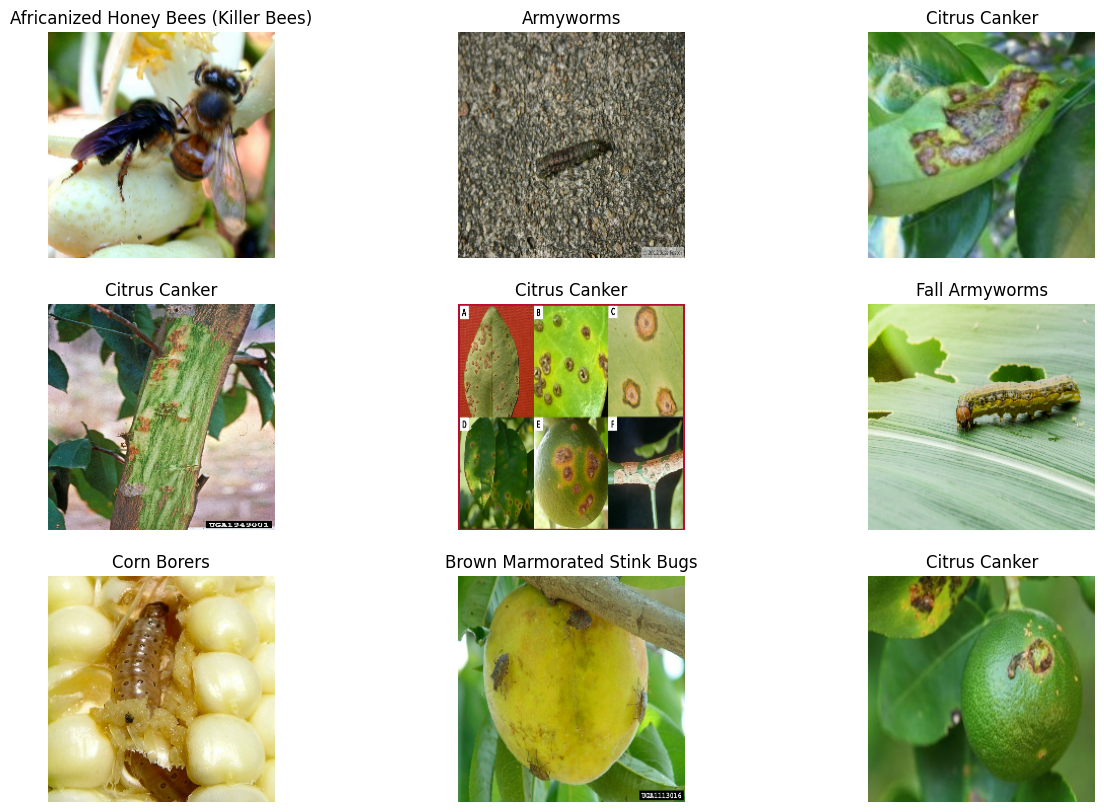

In [ ]:
# to show images from dataset
plt.figure(figsize=(15, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
# Normalize & Prefetch
normalization_layer = keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(tf.data.AUTOTUNE)

##**Modelling**

## Using Pre-Trained ResNet50V2

In [ ]:
# Model: ResNet50V2
base_model = keras.applications.ResNet50V2(
    weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Freezing all layers except the last 50 to fine-tune the model for the specific task while retaining learned features.
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

In [ ]:
# base_model Summary
base_model.summary()


Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 18,325,504 (69.91 MB)

 Non-trainable params: 5,239,296 (19.99 MB)

In [ ]:
model = keras.Sequential([
    keras.layers.Input(shape=IMG_SIZE + (3,)),
    keras.layers.RandomFlip(),
    keras.layers.RandomRotation(0.2),
    keras.layers.RandomZoom(0.1),
    keras.layers.Rescaling(1./255),
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 15)             │        30,735 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,595,535 (90.01 MB)

 Trainable params: 18,356,239 (70.02 MB)

 Non-trainable params: 5,239,296 (19.99 MB)

In [ ]:
# Callbacks
callbacks = [
    ReduceLROnPlateau(patience=2, verbose=1),
    EarlyStopping(patience=5, restore_best_weights=True)
]

In [ ]:
# Training
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 47s 231ms/step - accuracy: 0.0830 - loss: 2.7501 - val_accuracy: 0.0629 - val_loss: 2.7369 - learning_rate: 1.0000e-04
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 17s 190ms/step - accuracy: 0.1258 - loss: 2.6560 - val_accuracy: 0.0881 - val_loss: 2.7122 - learning_rate: 1.0000e-04
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 17s 186ms/step - accuracy: 0.1156 - loss: 2.6199 - val_accuracy: 0.0881 - val_loss: 2.7741 - learning_rate: 1.0000e-04
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.1302 - loss: 2.6181
Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
90/90 ━━━━━━━━━━━━━━━━━━━━ 18s 196ms/step - accuracy: 0.1303 - loss: 2.6180 - val_accuracy: 0.0943 - val_loss: 2.7229 - learning_rate: 1.0000e-04
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 18s 190ms/step - accuracy: 0.1547 - loss: 2.5440 - val_accuracy: 0.1950 - val_loss: 2.6184 - learning_rate: 1.0000e-05
Epoch 6/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 17s 185ms/step - acc

## Model Evaluation

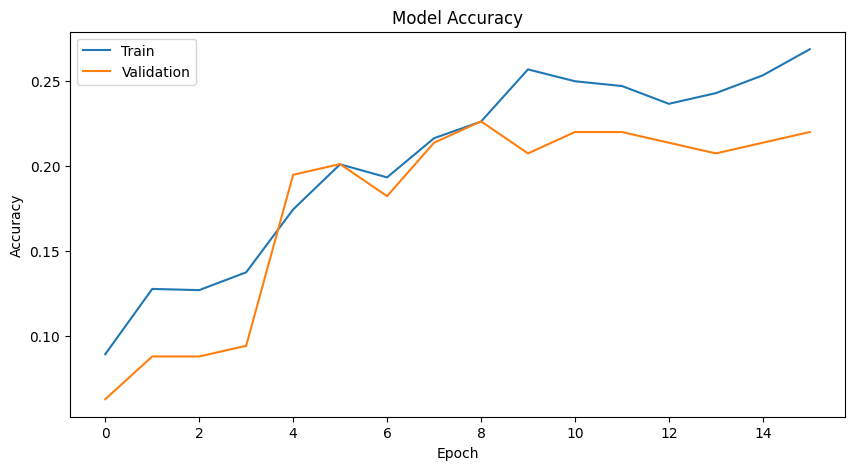

In [ ]:
# Plot training & validation accuracy

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Save the plot
plt.savefig('model_accuracy_plot.png', dpi=300)

plt.show()

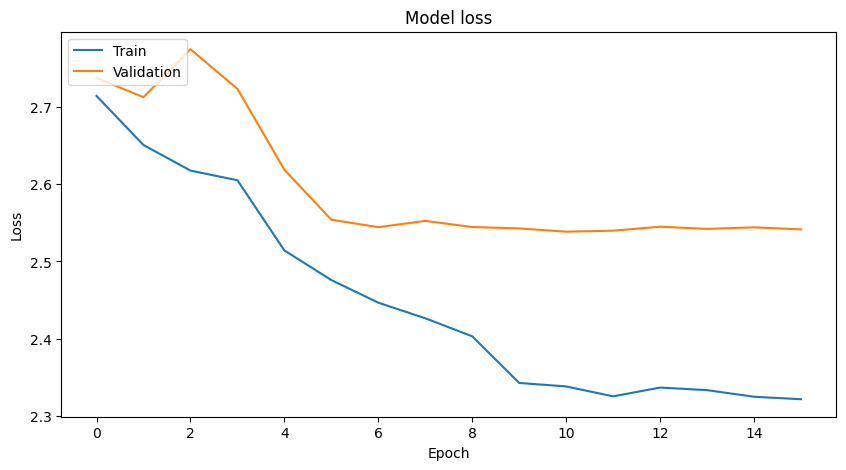

In [ ]:
# Plot training & validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

#save the plot
plt.savefig('model_loss_plot.png', dpi=300)

plt.show()

### Training data

In [ ]:
# Predict on training data
y_pred = model.predict(train_ds)
y_pred = np.argmax(y_pred, axis=1)

# Get true labels
y_true = []
for _, labels in train_ds:
    y_true.extend(labels.numpy())

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step
                                      precision    recall  f1-score   support

Africanized Honey Bees (Killer Bees)       0.06      0.10      0.07        87
                              Aphids       0.03      0.01      0.02        82
                           Armyworms       0.03      0.01      0.02        84
         Brown Marmorated Stink Bugs       0.10      0.18      0.13       102
                     Cabbage Loopers       0.14      0.05      0.08        94
                       Citrus Canker       0.09      0.13      0.11        94
             Colorado Potato Beetles       0.04      0.06      0.04       104
                         Corn Borers       0.08      0.04      0.05        99
                       Corn Earworms       0.06      0.03      0.04        99
                      Fall Armyworms       0.17      0.06      0.09        99
                         Fruit Flies       0.04      0.05      0.04        88
                     

### Validation Data

In [ ]:
# Predict on validation data
y_pred = model.predict(val_ds)
y_pred = np.argmax(y_pred, axis=1)

# Get true labels
y_true = []
for _, labels in val_ds:
    y_true.extend(labels.numpy())

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step
                                      precision    recall  f1-score   support

Africanized Honey Bees (Killer Bees)       0.10      0.20      0.13        10
                              Aphids       0.00      0.00      0.00         6
                           Armyworms       0.00      0.00      0.00        12
         Brown Marmorated Stink Bugs       0.05      0.08      0.06        12
                     Cabbage Loopers       0.25      0.10      0.14        10
                       Citrus Canker       0.00      0.00      0.00        10
             Colorado Potato Beetles       0.05      0.12      0.07         8
                         Corn Borers       0.00      0.00      0.00        16
                       Corn Earworms       0.20      0.09      0.12        11
                      Fall Armyworms       0.00      0.00      0.00        14
                         Fruit Flies       0.00      0.00      0.00        13
                      

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


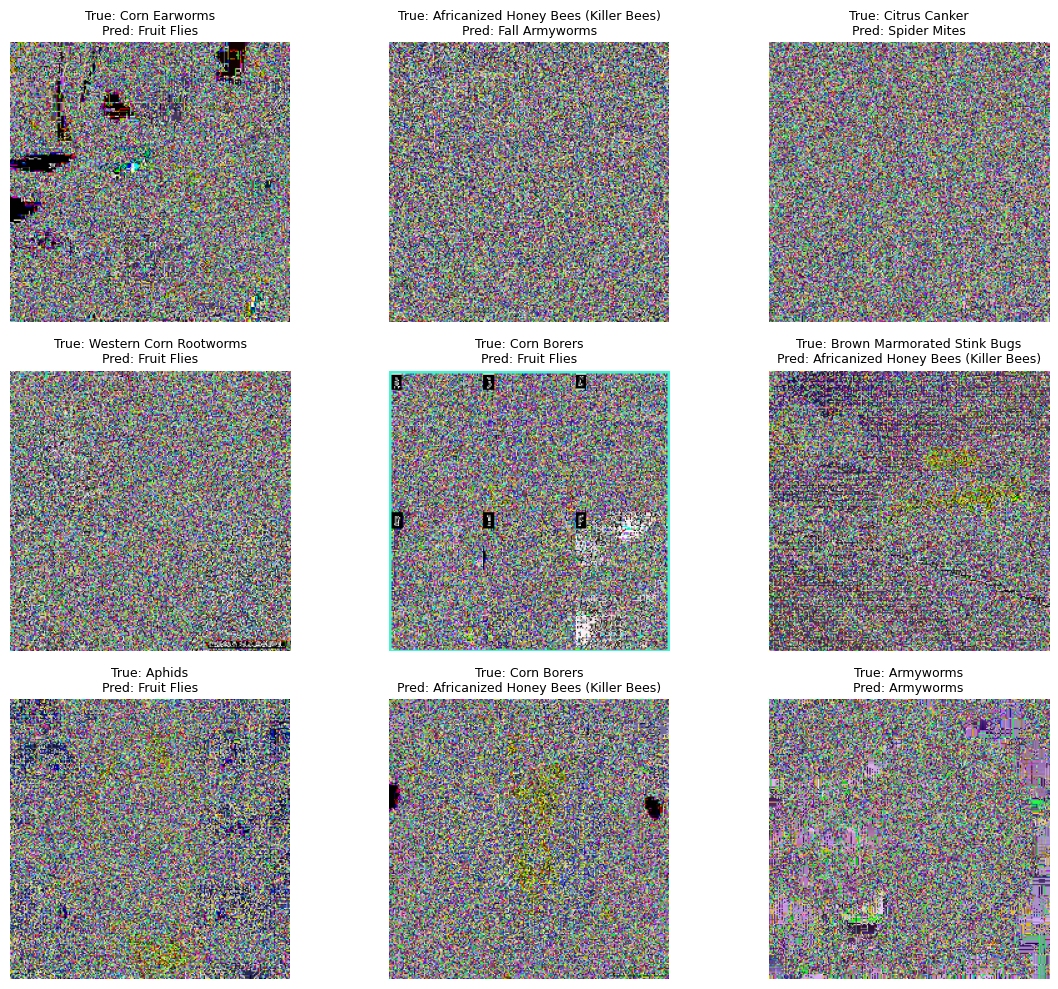

In [ ]:
plt.figure(figsize=(12, 10))  # Slightly compact size for 3x3 grid

# Get predictions for the current batch of images
pred_labels = model.predict(images)
pred_labels = np.argmax(pred_labels, axis=1) # Get the class with highest probability

for i in range(9):
    img = images[i].numpy() * 255.0
    img = img.astype("uint8")

    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[pred_labels[i]]}", fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()

## Saving model

In [ ]:
model.save("/content/drive/MyDrive/model.keras")